# TransUnet Model

## Module imoprts

In [1]:
# import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import os
import cv2
import import_ipynb
import Utils
# from skimage import util


In [2]:
from tensorflow.keras import layers,losses,Sequential,metrics
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from CBAM import ConvolutionBlockAttentionModule

## Reading the data

In [5]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

## Voxel Extraction

In [6]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [7]:
del image_data

## Model Config

In [8]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

## Loss functions

In [9]:
def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = tf.keras.losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution,model.learnedDistribution)
        return kl_loss
    return _calculate_kl_loss

def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse( y_target, y_predicted )
    return reconstruction_loss


def _calculate_porosity_loss(y_target,y_predicted):
    por1 = tf.reduce_mean(y_target,axis=(1, 2))
    por2 = tf.reduce_mean(y_predicted,axis=(1, 2))
    mae = losses.MeanSquaredError()
    return mae(por1,por2)
    

## Model Class

### Transformer Architecture

#### Patch Encoder

In [10]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    
    return output

#### Transformer Encoder

In [11]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    
    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )
    
    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    
  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

#### Vision Transformer

In [12]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS*2, 'gelu',kernel_initializer='glorot_uniform')
    self.dense_2 = Dense(N_DENSE_UNITS, activation = 'sigmoid',kernel_initializer='glorot_uniform')
  def call(self, inputs, training = True):

    x = self.patch_encoder(inputs)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    
    return self.dense_2(x)

##### ViT Example

In [12]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 256, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 64)
vit(tf.zeros([256,1,1,1]))

ValueError: in user code:

    C:\Users\TRETEC\AppData\Local\Temp\ipykernel_15716\2622848392.py:11 call  *
        x = self.patch_encoder(inputs)
    C:\Users\TRETEC\AppData\Local\Temp\ipykernel_15716\42480641.py:17 call  *
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\ops\array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:8396 reshape
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\framework\ops.py:3557 _create_op_internal
        ret = Operation(
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 0 elements to shape [256,256,256] (16777216 elements) for '{{node vision_transformer/patch_encoder/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](vision_transformer/patch_encoder/ExtractImagePatches, vision_transformer/patch_encoder/Reshape/shape)' with input shapes: [256,0,0,256], [3] and with input tensors computed as partial shapes: input[1] = [256,256,256].


In [13]:

vit.summary()

NameError: name 'vit' is not defined

In [14]:
class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=(256,256,1),
                 latent_space_dim = 64,
                 reducedDimension = 256,
                 convFilters = [16,32,64,128,256]
                )-> None:
        
        
        
        ##### inputs ######
        self.inputShape = inputShape # [256, 256, 1]
        self.latent_space_dim = latent_space_dim # 64
        self.reducedDimension = reducedDimension #256
        
        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1
        
        self.skipConnections = None

        self.learnedPrior = None
        self.inference = None
        self.Generate = None

        
        
        self.learnedDistribution = None
        self.inferenceDistribution = None
        
        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
    
    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.Generate.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    _calculate_porosity_loss,
                                    calculate_kl_loss(self)],
                             experimental_run_tf_function=False)
    
    def train(self, inputs1,inputs2, batch_size, num_epochs):
        return self.Generate.fit(x=[inputs1,inputs2],
                       y=inputs2,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       )
    
#     def save(self, save_folder="."):
#         self._create_folder_if_it_doesnt_exist(save_folder)
#         self._save_parameters(save_folder)
#         self._save_weights(save_folder)

#     def load_weights(self, weights_path):
#         self.model.load_weights(weights_path)


#      @classmethod
#     def load(cls, save_folder="."):
#         parameters_path = os.path.join(save_folder, "parameters.pkl")
#         with open(parameters_path, "rb") as f:
#             parameters = pickle.load(f)
#         autoencoder = Reconstruction(*parameters)
#         weights_path = os.path.join(save_folder, "weights.h5")
#         autoencoder.load_weights(weights_path)
#         return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        
        
        reconstruction_loss = _calculate_reconstruction_loss(y_target,y_predicted)
        kl_loss = calculate_kl_loss(self)(self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss * self.Kullback_leibler_weight\
                                                         + porisity_loss * self.porosity_Loss_weight
        return combined_loss
    


    def _build(self):
        self._build_inference()
        self._build_learned_prior()
        self._build_generate()
    
    ######  inference ########
    
    
        
    def _build_inference(self):
        self.inference = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 256, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 64)
        
        
    ######   learned prior ########
        
    def _build_learned_prior(self):
        
        self.learnedPrior = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 256, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 64)
    
    #### generate ######
    
    def _build_generate(self):
        

        
        input_learned = layers.Input(shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(shape=self.inputShape, name="inference_input")
        

        
        self.learnedDistribution = self.learnedPrior(input_learned)
        self.inferenceDistribution = self.inference(input_inference)
        
        
        
        
        conv_1 = layers.Conv2D(16, (3,3) ,input_shape = self.inputShape , activation='relu',
                               padding='same' , name="first_encoder_conv")(input_learned)
        bn1 = layers.BatchNormalization()(conv_1)
        mp1 = layers.MaxPooling2D((2,2), padding='same')(bn1)
        
        
        conv_2 = layers.Conv2D(32, (3,3) , activation='relu'
                               , padding='same' , name="second_encoder_conv" )(mp1)
        bn2 = layers.BatchNormalization()(conv_2)
        mp2 = layers.MaxPooling2D((2,2), padding='same')(bn2)
        
        
        conv_3 = layers.Conv2D(64, (3,3) , activation='relu'
                               , padding='same', name="third_encoder_conv")(mp2)
        bn3 = layers.BatchNormalization()(conv_3)
        mp3 = layers.MaxPooling2D((2,2), padding='same')(bn3)
        
        
        
        conv_4 = layers.Conv2D(128, (3,3) , activation='relu'
                               , padding='same' , name="fourth_encoder_conv")(mp3)
        bn4 = layers.BatchNormalization()(conv_4)
        mp4 = layers.MaxPooling2D((2,2), padding='same')(bn4)
        
        
        
        conv_5 = layers.Conv2D(256, (3,3), activation='relu'
                               , padding='same' , name="fifth_encoder_conv")(mp4)
        bn5 = layers.BatchNormalization()(conv_5)
        mp5 = layers.MaxPooling2D((2,2), padding='same')(bn5)
        
        flattened = layers.Flatten()(mp5)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        self.skipConnections = [bn5,bn4,bn3,bn2,bn1]
        
        conv_out = layers.Reshape(( 1 ,self.reducedDimension ))(conv_out)
        self.learnedDistribution = layers.Reshape(( 1 ,self.latent_space_dim ))(self.learnedDistribution)
        
        
        concated_input = layers.Concatenate(axis=-1)([conv_out,self.learnedDistribution])
        
        reshaped = layers.Reshape((1, self.reducedDimension + self.latent_space_dim))(concated_input)
        
        generated = layers.LSTM(self.reducedDimension, return_sequences=True,name="generate_LSTM")(reshaped)
        
        upDense = layers.Dense(8*8*256,name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)
        
        reshapedUp = layers.Reshape((8, 8, 256))(batchNorm_7)
        
        convT_1 = layers.Conv2DTranspose(256, (3,3), strides=2, activation='relu'
                                         , padding='same',name="first_decoder_conv")(reshapedUp)
        batchNorm_8 = layers.BatchNormalization()(convT_1)
        batchNorm_8 = layers.Add()([batchNorm_8,self.skipConnections[0]])
        
        cbam_1 = ConvolutionBlockAttentionModule()(batchNorm_8)
        convT_2 = layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu'
                                         , padding='same',name="second_decoder_conv")(cbam_1)
        batchNorm_9 = layers.BatchNormalization()(convT_2)
        batchNorm_9 = layers.Add()([batchNorm_9, self.skipConnections[1]])
        
        
        cbam_2 = ConvolutionBlockAttentionModule()(batchNorm_9)
        convT_3 = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu'
                                         , padding='same',name="third_decoder_conv")(cbam_2)
        batchNorm_10 = layers.BatchNormalization()(convT_3)
        batchNorm_10 = layers.Add()([batchNorm_10, self.skipConnections[2]])
        
        
        
        cbam_3 = ConvolutionBlockAttentionModule()(batchNorm_10)
        convT_4 = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu'
                                         , padding='same',name="fourth_decoder_conv")(cbam_3)
        batchNorm_11 = layers.BatchNormalization()(convT_4)
        batchNorm_11 = layers.Add()([batchNorm_11, self.skipConnections[3]])
        
        
        cbam_4 = ConvolutionBlockAttentionModule()(batchNorm_11)
        convT_5 = layers.Conv2DTranspose(16, (3,3), strides=2, activation='relu'
                                         , padding='same',name="fifth_decoder_conv")(cbam_4)
        batchNorm_12 = layers.BatchNormalization()(convT_5)
        batchNorm_12 = layers.Add()([batchNorm_12, self.skipConnections[4]])
        
        
        
        gen_out = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(batchNorm_12)
        
        self.Generate = Model([input_learned,input_inference], gen_out, name="generate")

## TensorFlow gpu setup

In [15]:
device = tf.config.list_physical_devices("GPU")
print(device)
tf.config.experimental.set_memory_growth(device[0],True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [17]:
tf.keras.backend.clear_session()

## Model creation

In [18]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()
batch_size = 10
epochs = 10

# for voxel in X_train:
#     reconstruction.train(voxel, batch_size, epochs)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
_________________________________________________________________
transformer_encoder (Transfo (None, 256, 256)          1184512   
_________________________________________________________________
transformer_encoder (Transfo (None, 256, 256)          1184512   
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
Total params: 10,897,344
Trainable params: 10,897,344
Non-trainable params: 0
_________________________________________________________________
Model: "vision_transformer"
__

## train and test data extraction

In [19]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [20]:
import numpy as np
print(np.__version__)

1.19.5


In [21]:
del voxels

## Creating model input


In [22]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)


## Training the model

In [23]:
histories = []
for i in range(len(learnedVoxels)):
    histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i], batch_size, epochs))

Train on 249 samples
Epoch 1/10
249/249 [==============================] - 15s 61ms/sample - loss: 0.2233 - _calculate_reconstruction_loss: 0.1802 - _calculate_porosity_loss: 0.0500 - _calculate_kl_loss: -7.2344
Epoch 2/10
249/249 [==============================] - 9s 35ms/sample - loss: 0.1120 - _calculate_reconstruction_loss: 0.0961 - _calculate_porosity_loss: 0.0312 - _calculate_kl_loss: -15.4249
Epoch 3/10
249/249 [==============================] - 9s 35ms/sample - loss: 0.0643 - _calculate_reconstruction_loss: 0.0643 - _calculate_porosity_loss: 0.0189 - _calculate_kl_loss: -18.9741
Epoch 4/10
249/249 [==============================] - 9s 35ms/sample - loss: 0.0440 - _calculate_reconstruction_loss: 0.0505 - _calculate_porosity_loss: 0.0127 - _calculate_kl_loss: -19.2098
Epoch 5/10
249/249 [==============================] - 9s 35ms/sample - loss: 0.0331 - _calculate_reconstruction_loss: 0.0429 - _calculate_porosity_loss: 0.0093 - _calculate_kl_loss: -19.2165
Epoch 6/10
249/249 [====

249/249 [==============================] - 11s 43ms/sample - loss: 0.0032 - _calculate_reconstruction_loss: 0.0222 - _calculate_porosity_loss: 6.2640e-05 - _calculate_kl_loss: -19.1324
Epoch 3/10
249/249 [==============================] - 11s 42ms/sample - loss: 5.6631e-04 - _calculate_reconstruction_loss: 0.0196 - _calculate_porosity_loss: 6.8426e-05 - _calculate_kl_loss: -19.1334
Epoch 4/10
249/249 [==============================] - 10s 42ms/sample - loss: -0.0013 - _calculate_reconstruction_loss: 0.0177 - _calculate_porosity_loss: 7.8408e-05 - _calculate_kl_loss: -19.1321
Epoch 5/10
249/249 [==============================] - 10s 42ms/sample - loss: -0.0025 - _calculate_reconstruction_loss: 0.0165 - _calculate_porosity_loss: 8.3628e-05 - _calculate_kl_loss: -19.1328
Epoch 6/10
249/249 [==============================] - 10s 42ms/sample - loss: -0.0036 - _calculate_reconstruction_loss: 0.0154 - _calculate_porosity_loss: 8.2235e-05 - _calculate_kl_loss: -19.1338
Epoch 7/10
249/249 [====

KeyboardInterrupt: 

## Testing the model

In [28]:

first  = X_test[0]
Topredict = first[1:]
test = first[:-1]


In [29]:
predicted = []


# for i in range(10):
predicted = reconstruction.Generate.predict([test,Topredict])
# predicted.append(nextLayer)
# #     inputLayer = nextLayer
# predicted.append()

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [30]:
len(predicted)

249

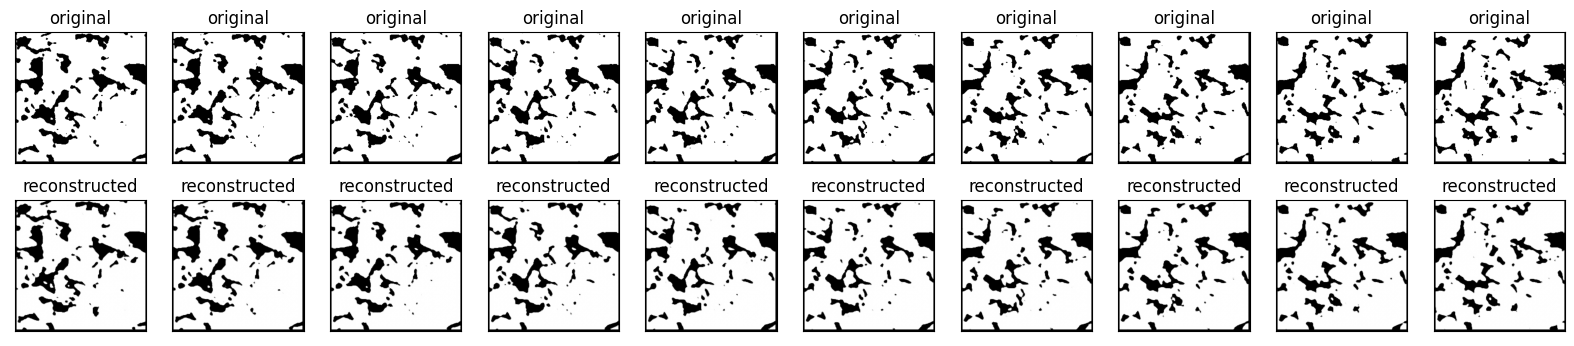

In [33]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(predicted[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [34]:
testing = []
inputLayer = test[0]
for i in range(10):
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),Topredict[i].reshape(1,256,256,1)]))
    inputLayer = testing[-1]

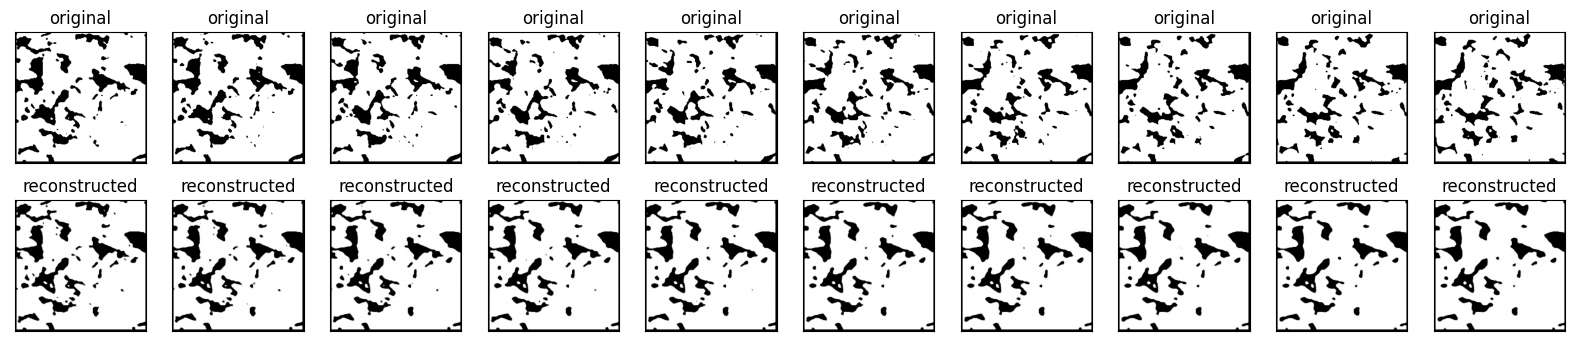

In [35]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)